# Breast Cancer Histology: Full Pipeline with Advanced Segmentation

This notebook implements the complete workflow using an SVM classifier and an advanced nuclei segmentation strategy:

1. Finds all relevant image paths and extracts patient/slide IDs.
2. Splits patient/slide IDs into Training and Testing sets (patient-level split).
3. Extracts features ONLY from the Training image set using advanced segmentation.
4. Cleans, preprocesses (scaling), and trains an SVM model on the Training features.
5. Extracts features ONLY from the Testing image set using advanced segmentation.
6. Cleans and preprocesses (using the scaler fitted on Training data) the Testing features.
7. Evaluates the trained SVM model on the unseen Testing features.

**Advanced Segmentation Strategy:**

- Color Deconvolution (Hematoxylin channel isolation)
- Adaptive Thresholding (Otsu) or Manual Thresholding
- Morphological Operations (Opening, Closing)
- Watershed Segmentation (Optional, for separating nuclei)
- Contour Filtering (Area, Circularity, per magnification)


## 1. Imports


In [23]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import pathlib
import json # For potentially loading/displaying config

from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
# ... (existing imports) ...
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # Import XGBoost


# Scikit-image for advanced segmentation
from skimage import color, exposure
# from scipy import ndimage # Not strictly needed if cv2.connectedComponents is used
# ... (other imports)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # Added GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
from sklearn.exceptions import NotFittedError

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Configuration


In [ ]:
# --- Path to Dataset ---
notebook_launch_dir = pathlib.Path.cwd()
ROOT_DATA_DIR = notebook_launch_dir / 'raw'

# --- Modeling Parameters ---
TEST_SET_SIZE = 0.25  # Proportion of unique patient/slide IDs for the test set
RANDOM_STATE = 42
NAN_HANDLING_STRATEGY = 'drop'  # 'drop' or 'impute_mean'

# --- Feature Names ---
FEATURE_NAMES_BASE = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                      'compactness', 'concavity', 'concave_points', 'symmetry',
                      'fractal_dimension']
# For Mean, Standard Error (SE), and Max of worst/largest nuclei features
FEATURE_COLUMNS = [f'{name}{suffix}' for name in FEATURE_NAMES_BASE for suffix in [
    '_mean', '_se', '_max']]

# --- YOUR TUNED SEGMENTATION CONFIGURATION ---

SEGMENTATION_CONFIG = {
    "contrast_stretch": False,
    "contrast_percentiles_low": 2,
    "contrast_percentiles_high": 98,
    "threshold_method": "otsu",
    "manual_threshold_value": 100,
    "morph_open_kernel_size": 1,
    "morph_open_iterations": 1,
    "morph_close_kernel_size": 3,
    "morph_close_iterations": 1,
    "use_watershed": False,
    "dist_transform_thresh_ratio": 0.3,
    "contour_filters_by_magnification": {
    "40X": {
    "min_area": 0,
    "max_area": 190,
    "min_circularity": 0.0,
    "dist_transform_thresh_ratio": 0.1
    },
    "100X": {
    "min_area": 5,
    "max_area": 1000,
    "min_circularity": 0.1,
    "dist_transform_thresh_ratio": 0.3
    },
    "200X": {
    "min_area": 100,
    "max_area": 30000,
    "min_circularity": 0.0,
    "dist_transform_thresh_ratio": 0.5
    },
    "400X": {
    "min_area": 200,
    "max_area": 10000,
    "min_circularity": 0.0,
    "dist_transform_thresh_ratio": 0.3
    }
}
}

## 3. Helper Functions (Segmentation, Feature Calculation, Evaluation)


In [25]:
def get_hematoxylin_channel(image_rgb):
    """Extracts the Hematoxylin channel using scikit-image's color deconvolution."""
    # Add a small epsilon to prevent division by zero or log of zero if image has pure black pixels
    image_rgb_safe = np.clip(image_rgb, 1, 255)
    ihc_hed = color.rgb2hed(image_rgb_safe)
    h_channel = ihc_hed[:, :, 0]
    # Normalize to 0-255, nuclei should be bright (higher values)
    h_channel_norm = cv2.normalize(h_channel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return h_channel_norm


def calculate_circularity(contour):
    """Calculates the circularity of a contour."""
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter == 0 or area == 0:
        return 0
    return (4 * np.pi * area) / (perimeter ** 2)


def segment_nuclei_pipeline(image_bgr, magnification, config):
    """Advanced nuclei segmentation for pipeline use. Returns only filtered contours."""
    if image_bgr is None:
        return []

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    h_channel = get_hematoxylin_channel(image_rgb)
    h_channel_processed = h_channel.copy()

    if config.get('contrast_stretch', False):
        p_low = config['contrast_percentiles_low']
        p_high = config['contrast_percentiles_high']
        if 0 <= p_low < p_high <= 100:
            p_low_val, p_high_val = np.percentile(
                h_channel_processed, (p_low, p_high))
            if p_low_val < p_high_val:  # Check if percentiles are distinct
                h_channel_processed = exposure.rescale_intensity(
                    h_channel_processed, in_range=(p_low_val, p_high_val))
                h_channel_processed = cv2.normalize(
                    h_channel_processed, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    if config['threshold_method'] == 'otsu':
        _, binary_mask = cv2.threshold(
            h_channel_processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:  # manual
        _, binary_mask = cv2.threshold(
            h_channel_processed, config['manual_threshold_value'], 255, cv2.THRESH_BINARY)

    open_k_size = config['morph_open_kernel_size']
    if open_k_size % 2 == 0:
        open_k_size += 1  # Ensure odd kernel size
    close_k_size = config['morph_close_kernel_size']
    if close_k_size % 2 == 0:
        close_k_size += 1  # Ensure odd kernel size

    kernel_open = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (open_k_size, open_k_size))
    opened_mask = cv2.morphologyEx(
        binary_mask, cv2.MORPH_OPEN, kernel_open, iterations=config['morph_open_iterations'])

    kernel_close = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (close_k_size, close_k_size))
    cleaned_mask = cv2.morphologyEx(
        opened_mask, cv2.MORPH_CLOSE, kernel_close, iterations=config['morph_close_iterations'])

    final_contours_list = []
    # Get magnification-specific filters, fallback to '200X' if current mag not found (should not happen with good config)
    mag_specific_filters = config['contour_filters_by_magnification'].get(magnification,
                                                                          config['contour_filters_by_magnification'].get('200X'))

    if config.get('use_watershed', True):
        sure_bg_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        sure_bg = cv2.dilate(cleaned_mask, sure_bg_kernel, iterations=3)
        dist_transform = cv2.distanceTransform(cleaned_mask, cv2.DIST_L2, 5)

        # Global fallback from main config
        default_global_dt_ratio = config.get(
            'dist_transform_thresh_ratio', 0.3)
        current_dist_thresh_ratio = mag_specific_filters.get(
            'dist_transform_thresh_ratio', default_global_dt_ratio)

        _, sure_fg = cv2.threshold(
            dist_transform, current_dist_thresh_ratio * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1  # So background is 1, not 0
        markers[unknown == 255] = 0  # Mark unknown region

        try:
            markers_copy = markers.copy()  # watershed modifies markers in-place
            # Use a copy for watershed if original image_rgb is needed later
            watershed_input_img = image_rgb.copy()
            cv2.watershed(watershed_input_img, markers_copy)

            # Use the modified markers_copy
            unique_marker_values = np.unique(markers_copy)
            for marker_val in unique_marker_values:
                # Skip background (1) and watershed boundary (-1)
                if marker_val <= 1:
                    continue
                nucleus_mask_ws = np.zeros(cleaned_mask.shape, dtype=np.uint8)
                nucleus_mask_ws[markers_copy == marker_val] = 255
                contours_ws, _ = cv2.findContours(
                    nucleus_mask_ws, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours_ws:
                    final_contours_list.extend(contours_ws)
        except cv2.error as e:
            # print(f"Pipeline Watershed failed (mag: {magnification}, file: {os.path.basename(image_bgr.name if hasattr(image_bgr, 'name') else 'N/A')}): {e}. Falling back.")
            contours_fb, _ = cv2.findContours(
                cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            final_contours_list = contours_fb
    else:  # No watershed
        contours_no_ws, _ = cv2.findContours(
            cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        final_contours_list = contours_no_ws

    min_area = mag_specific_filters['min_area']
    max_area = mag_specific_filters['max_area']
    min_circ = mag_specific_filters['min_circularity']

    filtered_contours = []
    for cnt in final_contours_list:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            circularity = calculate_circularity(cnt)
            if circularity >= min_circ:
                filtered_contours.append(cnt)
    return filtered_contours


def calculate_contour_features(contour, gray_image):
    """Calculates a dictionary of features for a single contour."""
    features = {}
    try:
        moments = cv2.moments(contour)
        area = cv2.contourArea(contour)
        if area <= 0:
            return None  # Skip invalid contours

        perimeter = cv2.arcLength(contour, True)
        equivalent_diameter = np.sqrt(4 * area / np.pi)
        features['radius'] = equivalent_diameter / 2.0

        # Texture (standard deviation of gray levels within the contour)
        mask = np.zeros(gray_image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, color=255, thickness=cv2.FILLED)
        mean_val, stddev_val = cv2.meanStdDev(gray_image, mask=mask)
        features['texture'] = stddev_val[0][0] if stddev_val is not None and stddev_val.size > 0 else 0.0

        features['perimeter'] = perimeter
        features['area'] = area

        # Smoothness (std of distances from center to contour points)
        if moments['m00'] > 0 and len(contour) > 1:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            center = np.array([cx, cy])
            contour_points = contour.reshape(-1, 2)
            distances = np.sqrt(np.sum((contour_points - center)**2, axis=1))
            features['smoothness'] = np.std(
                distances) if distances.size > 0 else 0.0
        else:
            features['smoothness'] = 0.0

        # Compactness
        features['compactness'] = (perimeter ** 2) / area if area > 0 else 0.0

        # Concavity (related to solidity)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area > 0:
            # (hull_area - area) / hull_area
            features['concavity'] = 1.0 - (area / hull_area)
        else:
            features['concavity'] = 0.0

        # Concave points (number of significant concavities)
        try:
            if len(contour) > 3:  # Need at least 4 points for convexityDefects
                hull_indices = cv2.convexHull(
                    contour, returnPoints=False)  # Get indices for defects
                if hull_indices is not None and len(hull_indices) > 3:
                    defects = cv2.convexityDefects(contour, hull_indices)
                    concave_points_count = 0
                    if defects is not None:
                        # Heuristic: defect depth must be at least 5% of diameter
                        min_defect_depth_ratio = 0.05
                        min_depth_pixels = min_defect_depth_ratio * equivalent_diameter
                        for i in range(defects.shape[0]):
                            s, e, f, d = defects[i, 0]
                            # s: start_index, e: end_index, f: farthest_point_index, d: depth (fixed-point)
                            depth = d / 256.0  # Convert depth to pixels
                            if depth > min_depth_pixels:
                                concave_points_count += 1
                        features['concave_points'] = concave_points_count
                    else:
                        features['concave_points'] = 0
                else:
                    features['concave_points'] = 0
            else:
                features['concave_points'] = 0
        except cv2.error:  # Catch OpenCV errors during defect calculation
            features['concave_points'] = 0

        # Symmetry (ratio of minor to major axis of fitted ellipse)
        if len(contour) >= 5:  # fitEllipse needs at least 5 points
            try:
                (x, y), (ma, MA), angle = cv2.fitEllipse(contour)
                # Ratio of minor to major axis
                features['symmetry'] = ma / MA if MA > 0 else 1.0
            except cv2.error:  # Handle cases where ellipse fitting fails
                # Or some other default for non-fittable shapes
                features['symmetry'] = 0.0
        else:
            features['symmetry'] = 0.0  # Not enough points to fit ellipse

        # Fractal dimension (approximate, e.g., perimeter / sqrt(area))
        features['fractal_dimension'] = perimeter / \
            np.sqrt(area) if area > 0 else 0.0

        return features

    except Exception as e:
        # print(f"Error calculating features for a contour: {e}")
        return None

## 4. Gather Image Paths and Split Data (Patient-Level)


In [26]:
all_image_paths_info = []
print(f"Scanning directory: {ROOT_DATA_DIR}...")

for root, dirs, files in os.walk(ROOT_DATA_DIR):
    path_parts = list(pathlib.Path(root).parts)
    # Example path: ./raw/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X
    # We need at least up to patient_id and magnification folder
    if len(path_parts) >= 7 and 'X' in path_parts[-1] and files:
        try:
            magnification = path_parts[-1]
            if magnification != '40X':
                continue
            patient_slide_id = path_parts[-2]  # e.g., SOB_M_DC_14-10926
            # sub_diagnosis_type = path_parts[-3] # e.g., ductal_carcinoma
            # sob_or_cnb = path_parts[-4] # e.g., SOB
            main_diagnosis_folder = path_parts[-5]  # e.g., malignant or benign

            if main_diagnosis_folder.lower() not in ['benign', 'malignant']:
                continue  # Skip if not a primary diagnosis folder

            diagnosis_label = 'M' if main_diagnosis_folder.lower() == 'malignant' else 'B'

            # Check if magnification is configured
            if magnification not in SEGMENTATION_CONFIG['contour_filters_by_magnification']:
                # print(f"Skipping unconfigured magnification: {magnification} in {root}")
                continue

            for file_name in files:
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    all_image_paths_info.append({
                        'path': os.path.join(root, file_name),
                        'filename': file_name,
                        'diagnosis': diagnosis_label,
                        'magnification': magnification,
                        'patient_slide_id': patient_slide_id
                    })
        except IndexError:
            # print(f"Skipping path due to unexpected structure: {root}")
            continue
        except Exception as e:
            print(f"Error parsing path info for {root}: {e}")

print(
    f"Found {len(all_image_paths_info)} total relevant images from {len(set(item['patient_slide_id'] for item in all_image_paths_info))} unique patient/slides.")

train_image_info_list, test_image_info_list = [], []
df_all_images = pd.DataFrame()

if not all_image_paths_info:
    print("CRITICAL ERROR: No images found. Pipeline cannot continue.")
else:
    df_all_images = pd.DataFrame(all_image_paths_info)
    print(f"\nSplitting patient/slide IDs into Train/Test sets (Patient-Level Split)...")

    unique_patient_slide_ids = df_all_images['patient_slide_id'].unique()
    # For stratification, get the diagnosis associated with each patient/slide ID (e.g., from its first image entry)
    patient_diagnoses = df_all_images.groupby('patient_slide_id')[
        'diagnosis'].first()

    if len(unique_patient_slide_ids) < 2 or (len(unique_patient_slide_ids) >= 2 and len(patient_diagnoses.loc[unique_patient_slide_ids].unique()) < 2):
        print(
            f"Warning: Not enough unique patient/slide IDs ({len(unique_patient_slide_ids)}) or distinct diagnosis groups among them for stratified patient-level split.")
        if len(unique_patient_slide_ids) == 1:
            print("Only one patient/slide ID found. Assigning all to training set.")
            train_patient_ids = unique_patient_slide_ids
            test_patient_ids = np.array([])
        elif len(unique_patient_slide_ids) > 1:  # Can do random split
            print("Attempting random split of patient/slide IDs instead.")
            train_patient_ids, test_patient_ids = train_test_split(
                unique_patient_slide_ids, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
            )
        else:  # No patients
            train_patient_ids, test_patient_ids = np.array([]), np.array([])
    else:
        try:
            train_patient_ids, test_patient_ids = train_test_split(
                unique_patient_slide_ids,
                test_size=TEST_SET_SIZE,
                random_state=RANDOM_STATE,
                # Stratify on the series of patient diagnoses
                stratify=patient_diagnoses.loc[unique_patient_slide_ids]
            )
        except ValueError as e:
            print(
                f"Error during stratified patient-level split: {e}. Falling back to random split.")
            train_patient_ids, test_patient_ids = train_test_split(
                unique_patient_slide_ids, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
            )

    if train_patient_ids.size > 0:
        train_image_info_list = df_all_images[df_all_images['patient_slide_id'].isin(
            train_patient_ids)].to_dict('records')
    if test_patient_ids.size > 0:
        test_image_info_list = df_all_images[df_all_images['patient_slide_id'].isin(
            test_patient_ids)].to_dict('records')

    print(f"Total unique patient/slide IDs: {len(unique_patient_slide_ids)}")
    print(f"Training patient/slide IDs: {len(train_patient_ids)}")
    print(f"Testing patient/slide IDs:  {len(test_patient_ids)}")
    print(f"Training image count: {len(train_image_info_list)}")
    print(f"Testing image count:  {len(test_image_info_list)}")

    # Sanity Check for patient overlap
    if train_patient_ids.size > 0 and test_patient_ids.size > 0:
        common_patients = set(train_patient_ids).intersection(
            set(test_patient_ids))
        if common_patients:
            print(
                f"CRITICAL ERROR IN SPLIT: Patients found in both train and test sets: {common_patients}")
        else:
            print(
                "Patient-level split successful: No patient/slide ID overlap between train and test sets.")

Scanning directory: /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/raw...
Found 1995 total relevant images from 82 unique patient/slides.

Splitting patient/slide IDs into Train/Test sets (Patient-Level Split)...
Total unique patient/slide IDs: 82
Training patient/slide IDs: 61
Testing patient/slide IDs:  21
Training image count: 1426
Testing image count:  569
Patient-level split successful: No patient/slide ID overlap between train and test sets.


## 5. Feature Extraction Function


In [27]:
def extract_features_for_paths(image_info_list, desc="Extracting Features"):
    all_features_data = []
    # Define output columns including ID, Diagnosis, Magnification, and all feature columns
    output_cols = ['ID', 'Diagnosis', 'Magnification',
                   'PatientSlideID'] + FEATURE_COLUMNS

    for img_info in tqdm(image_info_list, desc=desc):
        img_path = img_info['path']
        image_id = img_info['filename']  # Using filename as ID for the row
        diagnosis = img_info['diagnosis']
        magnification = img_info['magnification']
        patient_slide_id = img_info['patient_slide_id']

        # Initialize a dictionary for this image's row with NaNs for all feature columns
        row_result = {'ID': image_id, 'Diagnosis': diagnosis,
                      'Magnification': magnification, 'PatientSlideID': patient_slide_id}
        for col in FEATURE_COLUMNS:
            row_result[col] = np.nan

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                all_features_data.append(row_result)  # Append row with NaNs
                continue

            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Use the new advanced segmentation function
            nuclei_contours = segment_nuclei_pipeline(
                image, magnification, SEGMENTATION_CONFIG)

            if not nuclei_contours:
                # No nuclei found, append row with NaNs
                all_features_data.append(row_result)
                continue

            # Calculate features for each detected nucleus
            nucleus_features_list = []
            for contour in nuclei_contours:
                features = calculate_contour_features(contour, gray_image)
                if features:  # If feature calculation was successful
                    nucleus_features_list.append(features)

            if not nucleus_features_list:
                # No valid features calculated, append NaNs
                all_features_data.append(row_result)
                continue

            df_nuclei = pd.DataFrame(nucleus_features_list)
            num_nuclei = len(df_nuclei)

            # Aggregate features (mean, standard error, max of largest/worst)
            for base_feature_name in FEATURE_NAMES_BASE:
                if base_feature_name in df_nuclei.columns:
                    feature_values = pd.to_numeric(
                        df_nuclei[base_feature_name], errors='coerce').dropna()
                    if not feature_values.empty:
                        row_result[f'{base_feature_name}_mean'] = feature_values.mean(
                        )
                        # Standard Error of the Mean (SEM)
                        row_result[f'{base_feature_name}_se'] = feature_values.std(
                        ) / math.sqrt(num_nuclei) if num_nuclei > 1 else 0.0
                        # For '_max', it's often interpreted as the 'worst' or largest value among the nuclei
                        row_result[f'{base_feature_name}_max'] = feature_values.max(
                        )

            all_features_data.append(row_result)

        except Exception as e:
            print(
                f"Error processing {img_path}: {e}. Appending row with NaNs.")
            # Append row with NaNs in case of any error
            all_features_data.append(row_result)

    return pd.DataFrame(all_features_data, columns=output_cols)

## 6. Extract Features for Training and Testing Sets


In [28]:
df_train_features = pd.DataFrame(
    columns=['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS)
df_test_features = pd.DataFrame(
    columns=['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS)

if train_image_info_list:
    print("\n--- Extracting Features for Training Set ---")
    df_train_features = extract_features_for_paths(
        train_image_info_list, desc="Training Set Features")
    print(f"Training features extracted. Shape: {df_train_features.shape}")
    print(df_train_features.head())
else:
    print("\nSkipping training feature extraction: No training images.")

if test_image_info_list:
    print("\n--- Extracting Features for Testing Set ---")
    df_test_features = extract_features_for_paths(
        test_image_info_list, desc="Testing Set Features")
    print(f"Testing features extracted. Shape: {df_test_features.shape}")
    print(df_test_features.head())
else:
    print("\nSkipping testing feature extraction: No testing images.")


--- Extracting Features for Training Set ---


Training Set Features:   0%|          | 0/1426 [00:00<?, ?it/s]

Training features extracted. Shape: (1426, 34)
                             ID Diagnosis Magnification     PatientSlideID  \
0  SOB_M_MC-14-18842-40-001.png         M           40X  SOB_M_MC_14-18842   
1  SOB_M_MC-14-18842-40-009.png         M           40X  SOB_M_MC_14-18842   
2  SOB_M_MC-14-18842-40-007.png         M           40X  SOB_M_MC_14-18842   
3  SOB_M_MC-14-18842-40-014.png         M           40X  SOB_M_MC_14-18842   
4  SOB_M_MC-14-18842-40-008.png         M           40X  SOB_M_MC_14-18842   

   radius_mean  radius_se  radius_max  texture_mean  texture_se  texture_max  \
0     1.930399   0.061796    7.766577      4.556428    0.105703    16.949598   
1     1.875057   0.133037    6.407962      4.988563    0.260836    14.448423   
2     1.883054   0.067114    7.684171      5.079319    0.141227    16.586920   
3     1.980080   0.071168    7.091753      4.890572    0.132308    14.707904   
4     1.706734   0.199189    5.957479      5.269505    0.444351    12.628658   

   

Testing Set Features:   0%|          | 0/569 [00:00<?, ?it/s]

Testing features extracted. Shape: (569, 34)
                             ID Diagnosis Magnification     PatientSlideID  \
0  SOB_M_MC-14-12773-40-022.png         M           40X  SOB_M_MC_14-12773   
1  SOB_M_MC-14-12773-40-025.png         M           40X  SOB_M_MC_14-12773   
2  SOB_M_MC-14-12773-40-005.png         M           40X  SOB_M_MC_14-12773   
3  SOB_M_MC-14-12773-40-023.png         M           40X  SOB_M_MC_14-12773   
4  SOB_M_MC-14-12773-40-024.png         M           40X  SOB_M_MC_14-12773   

   radius_mean  radius_se  radius_max  texture_mean  texture_se  texture_max  \
0     1.662779   0.061007    7.756324      4.127263    0.117741    17.666001   
1     1.838732   0.105112    7.091753      5.069970    0.226596    11.630325   
2     2.004232   0.060797    7.621782      4.493722    0.112294    17.413304   
3     1.780864   0.054585    7.735778      4.216710    0.107067    15.558740   
4     1.882295   0.074837    7.715177      5.216291    0.158105    14.519266   

   pe

## 7. Data Cleaning & Preprocessing


In [29]:
scaler = StandardScaler()
le = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # Using mean for imputation if chosen

X_train_scaled = pd.DataFrame()
y_train = np.array([])
X_test_scaled = pd.DataFrame()
y_test = np.array([])

if not df_train_features.empty:
    print("\n--- Preprocessing Training Data ---")
    df_train_clean = df_train_features.copy()
    initial_train_rows = df_train_clean.shape[0]

    # NaN handling for FEATURE_COLUMNS only
    nan_rows_train_count = df_train_clean[FEATURE_COLUMNS].isnull().any(
        axis=1).sum()
    if nan_rows_train_count > 0:
        if NAN_HANDLING_STRATEGY == 'drop':
            print(
                f"Strategy: Dropping {nan_rows_train_count} training rows with NaNs in features.")
            df_train_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
        elif NAN_HANDLING_STRATEGY == 'impute_mean':
            print(f"Strategy: Imputing NaNs in training features with column mean.")
            df_train_clean[FEATURE_COLUMNS] = imputer.fit_transform(
                df_train_clean[FEATURE_COLUMNS])
    print(
        f"Training rows after NaN handling: {df_train_clean.shape[0]} (out of {initial_train_rows})")

    if not df_train_clean.empty:
        X_train = df_train_clean[FEATURE_COLUMNS]
        y_train_raw = df_train_clean['Diagnosis']
        y_train = le.fit_transform(y_train_raw)
        print(f"Target variable 'Diagnosis' encoded. Classes: {le.classes_}")

        X_train_scaled_np = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(
            X_train_scaled_np, columns=FEATURE_COLUMNS, index=X_train.index)
        print("Training features scaled.")
    else:
        print("Training data is empty after NaN handling. Cannot proceed with training.")
else:
    print("\nTraining features dataframe is empty. Cannot preprocess.")


if not df_test_features.empty and not X_train_scaled.empty:  # Ensure training preprocessing happened
    print("\n--- Preprocessing Testing Data ---")
    df_test_clean = df_test_features.copy()
    initial_test_rows = df_test_clean.shape[0]

    nan_rows_test_count = df_test_clean[FEATURE_COLUMNS].isnull().any(
        axis=1).sum()
    if nan_rows_test_count > 0:
        if NAN_HANDLING_STRATEGY == 'drop':
            print(
                f"Strategy: Dropping {nan_rows_test_count} testing rows with NaNs in features.")
            df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
        elif NAN_HANDLING_STRATEGY == 'impute_mean':
            print(
                f"Strategy: Imputing NaNs in testing features using imputer fitted on training data.")
            try:
                df_test_clean[FEATURE_COLUMNS] = imputer.transform(
                    df_test_clean[FEATURE_COLUMNS])
            except NotFittedError:
                print(
                    "Error: Imputer not fitted (likely no NaNs in training or impute strategy not used). Dropping test NaNs.")
                df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
            except Exception as e:
                print(f"Error imputing test NaNs: {e}. Dropping test NaNs.")
                df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
    print(
        f"Testing rows after NaN handling: {df_test_clean.shape[0]} (out of {initial_test_rows})")

    if not df_test_clean.empty:
        X_test = df_test_clean[FEATURE_COLUMNS]
        y_test_raw = df_test_clean['Diagnosis']
        try:
            # Use already fitted LabelEncoder
            y_test = le.transform(y_test_raw)
            print("Test target encoded.")
        except ValueError as e:
            print(
                f"Warning: Error encoding test labels (some labels might be new or missing): {e}.")
            # Handle new labels - for now, we might just assign a placeholder or filter these rows
            # A robust way is to ensure all labels in test are also in train, or handle them gracefully.
            # For simplicity here, we'll try to proceed but evaluation might be tricky.
            # Placeholder for unencodeable labels
            y_test = np.array([-1] * len(y_test_raw))

        try:
            X_test_scaled_np = scaler.transform(
                X_test)  # Use already fitted Scaler
            X_test_scaled = pd.DataFrame(
                X_test_scaled_np, columns=FEATURE_COLUMNS, index=X_test.index)
            print("Testing features scaled.")
        except NotFittedError:
            print(
                "Error: Scaler not fitted (training data might have been empty). Cannot scale test data.")
            X_test_scaled = pd.DataFrame()  # Ensure it's empty
        except Exception as e:
            print(f"Error scaling test data: {e}")
            X_test_scaled = pd.DataFrame()
    else:
        print("Testing data is empty after NaN handling.")
elif df_test_features.empty:
    print("\nTesting features dataframe is empty. Cannot preprocess.")
else:  # X_train_scaled is empty
    print("\nTraining data was not processed. Skipping test data preprocessing.")


--- Preprocessing Training Data ---
Strategy: Dropping 1 training rows with NaNs in features.
Training rows after NaN handling: 1425 (out of 1426)
Target variable 'Diagnosis' encoded. Classes: ['B' 'M']
Training features scaled.

--- Preprocessing Testing Data ---
Strategy: Dropping 1 testing rows with NaNs in features.
Testing rows after NaN handling: 568 (out of 569)
Test target encoded.
Testing features scaled.


## 8. Model Training


In [30]:
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix

models = {}
model_accuracies = {}
model_cms = {}
model_roc_aucs = {}

if not X_train_scaled.empty and y_train.size > 0:
    print("\n--- Training All Models ---")
    
    # Apply SMOTE oversampling on training data to balance classes
    # sm = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = (X_train_scaled, y_train)
    
    # 1. Support Vector Classification (SVC)
    print("\nTraining Support Vector Classifier...")
    svc_model = SVC(
        kernel='rbf', C=10.0, gamma='scale', probability=True,
        random_state=RANDOM_STATE, class_weight='balanced'
    )
    try:
        svc_model.fit(X_train_resampled, y_train_resampled)
        models['SVC'] = svc_model
        print("SVC Model Trained.")
    except Exception as e:
        print(f"Error training SVC: {e}")
        models['SVC'] = None

    # 2. XGBoost Classifier
    print("\nTraining XGBoost Classifier...")
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        scale_pos_weight=scale_pos_weight,
        min_child_weight=1
    )
    try:
        xgb_model.fit(X_train_resampled, y_train_resampled)
        models['XGBoost'] = xgb_model
        print("XGBoost Model Trained.")
    except Exception as e:
        print(f"Error training XGBoost: {e}")
        models['XGBoost'] = None

    # 3. Random Forest Classifier
    print("\nTraining Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=200, max_depth=5,
        random_state=RANDOM_STATE, class_weight='balanced'
    )
    try:
        rf_model.fit(X_train_resampled, y_train_resampled)
        models['RandomForest'] = rf_model
        print("Random Forest Model Trained.")
    except Exception as e:
        print(f"Error training Random Forest: {e}")
        models['RandomForest'] = None

    # 4. Neural Network Classifier (MLP)
    print("\nTraining Neural Network (MLP) Classifier...")
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(50,),
        max_iter=1000,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=20
    )
    try:
        mlp_model.fit(X_train_resampled, y_train_resampled)
        models['MLP'] = mlp_model
        print("MLP Model Trained.")
    except Exception as e:
        print(f"Error training MLP: {e}")
        models['MLP'] = None

    # 5. Logistic Regression
    print("\nTraining Logistic Regression Classifier...")
    lr_model = LogisticRegression(
        solver='liblinear',
        random_state=RANDOM_STATE,
        class_weight='balanced',
        max_iter=200
    )
    try:
        lr_model.fit(X_train_resampled, y_train_resampled)
        models['LogisticRegression'] = lr_model
        print("Logistic Regression Model Trained.")
    except Exception as e:
        print(f"Error training Logistic Regression: {e}")
        models['LogisticRegression'] = None

else:
    print("\nSkipping model training due to lack of processed training data or labels.")



--- Training All Models ---

Training Support Vector Classifier...
SVC Model Trained.

Training XGBoost Classifier...


/home/sih/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Trained.

Training Random Forest Classifier...
Random Forest Model Trained.

Training Neural Network (MLP) Classifier...
MLP Model Trained.

Training Logistic Regression Classifier...
Logistic Regression Model Trained.


# 10. Model Evaluation


In [31]:
def evaluate_model(model_name, model, X_test_data, y_true_encoded, le_encoder):
    print(f"\\n--- Evaluation Metrics for: {model_name} on Test Set ---")
    if model is None:
        print("Model was not trained or training failed.")
        return 0.0, None, None
    if X_test_data.empty:
        print("Test data is empty.")
        return 0.0, None, None
    # Ensure y_true_encoded is not empty and doesn't contain only -1 (placeholder for encoding errors)
    if len(y_true_encoded) == 0 or (isinstance(y_true_encoded, np.ndarray) and np.all(y_true_encoded == -1)):
        print("Test labels are invalid or empty.")
        return 0.0, None, None

    y_pred, y_prob = None, None
    try:
        y_pred = model.predict(X_test_data)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_data)[:, 1]
        else:
            print(
                f"Model {model_name} does not support predict_proba, ROC AUC cannot be calculated.")
    except NotFittedError:
        print(
            f"Error: Model {model_name} is not fitted. Cannot make predictions.")
        return 0.0, None, None
    except Exception as e:
        print(f"Error during prediction for {model_name}: {e}")
        return 0.0, None, None

    accuracy = accuracy_score(y_true_encoded, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\\nClassification Report:")
    try:
        present_labels_in_true_or_pred = np.unique(
            np.concatenate((y_true_encoded, y_pred)))
        # Filter out -1 if it was used as a placeholder for unencodeable labels
        present_labels = [
            label for label in present_labels_in_true_or_pred if label != -1]

        if not present_labels:  # If only -1 was present or became present
            print("No valid labels found for classification report after filtering.")
            print(classification_report(y_true_encoded,
                  y_pred, zero_division=0))  # Fallback
        else:
            present_target_names = le_encoder.inverse_transform(present_labels)
            print(classification_report(y_true_encoded, y_pred, labels=present_labels,
                  target_names=present_target_names, zero_division=0))
    except Exception as e:
        print(
            f"Could not generate full classification report for {model_name}: {e}")
        print(classification_report(y_true_encoded, y_pred, zero_division=0))

    print("\\nConfusion Matrix:")
    # Ensure labels for confusion matrix are only those present in the encoder
    # Use only valid labels from y_true for CM
    cm_labels = [l for l in np.unique(y_true_encoded) if l != -1]
    if not cm_labels:  # If y_true only contained -1 or was empty
        cm_labels_for_sklearn = le_encoder.transform(
            le_encoder.classes_)  # Default to all known classes
    else:
        cm_labels_for_sklearn = cm_labels

    if not list(cm_labels_for_sklearn):  # If still no valid labels
        print("No valid labels to display confusion matrix.")
        cm = None
    else:
        cm = confusion_matrix(y_true_encoded, y_pred,
                              labels=cm_labels_for_sklearn)
        plt.figure(figsize=(6, 4))
        # Use le.classes_ for tick labels as they represent the full potential set
        tick_labels = le_encoder.inverse_transform(cm_labels_for_sklearn) if list(
            cm_labels_for_sklearn) else le_encoder.classes_
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=tick_labels, yticklabels=tick_labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

    roc_auc = None
    # Ensure there are at least two unique, valid classes in y_true_encoded for ROC AUC
    valid_y_true_for_roc = y_true_encoded[y_true_encoded != -1]
    if y_prob is not None and len(np.unique(valid_y_true_for_roc)) > 1:
        fpr, tpr, _ = roc_curve(valid_y_true_for_roc, y_prob[y_true_encoded != -1] if len(
            y_prob) == len(y_true_encoded) else y_prob)  # Ensure y_prob aligns
        roc_auc = auc(fpr, tpr)
        print(f"\\nROC AUC Score: {roc_auc:.4f}")
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    elif y_prob is None:
        print(
            f"ROC AUC cannot be calculated for {model_name} as y_prob is not available.")
    else:  # Only one class in valid_y_true_for_roc
        print(
            f"ROC AUC cannot be calculated for {model_name} because there is only one class present in valid y_true labels.")

    return accuracy, cm, roc_auc

# 10. Model Training


\n\n=== Evaluating All Models on Test Set ===
\n--- Evaluating SVC ---
\n--- Evaluation Metrics for: SVC on Test Set ---
Accuracy: 0.7254
\nClassification Report:
              precision    recall  f1-score   support

           B       0.57      0.59      0.58       182
           M       0.80      0.79      0.80       386

    accuracy                           0.73       568
   macro avg       0.69      0.69      0.69       568
weighted avg       0.73      0.73      0.73       568

\nConfusion Matrix:


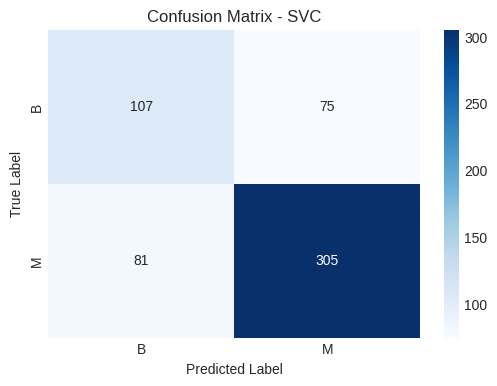

\nROC AUC Score: 0.7586


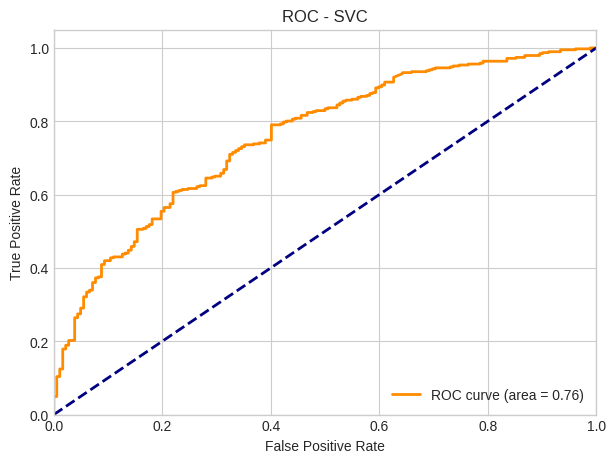

\n--- Evaluating XGBoost ---
\n--- Evaluation Metrics for: XGBoost on Test Set ---
Accuracy: 0.6690
\nClassification Report:
              precision    recall  f1-score   support

           B       0.48      0.41      0.44       182
           M       0.74      0.79      0.76       386

    accuracy                           0.67       568
   macro avg       0.61      0.60      0.60       568
weighted avg       0.66      0.67      0.66       568

\nConfusion Matrix:


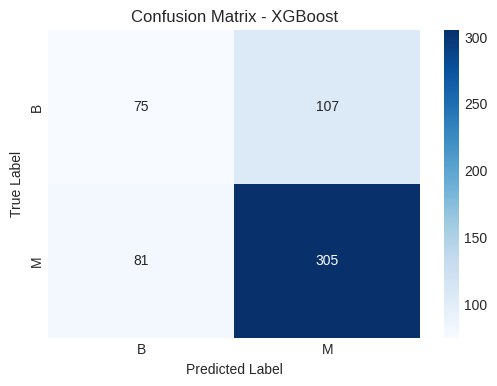

\nROC AUC Score: 0.6505


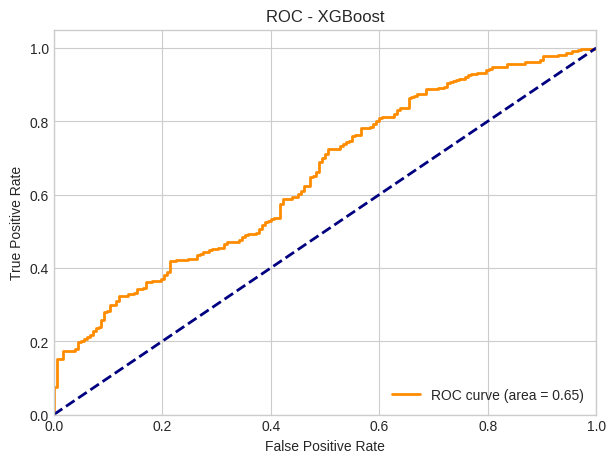

\n--- Evaluating RandomForest ---
\n--- Evaluation Metrics for: RandomForest on Test Set ---
Accuracy: 0.6989
\nClassification Report:
              precision    recall  f1-score   support

           B       0.55      0.34      0.42       182
           M       0.74      0.87      0.80       386

    accuracy                           0.70       568
   macro avg       0.64      0.60      0.61       568
weighted avg       0.68      0.70      0.68       568

\nConfusion Matrix:


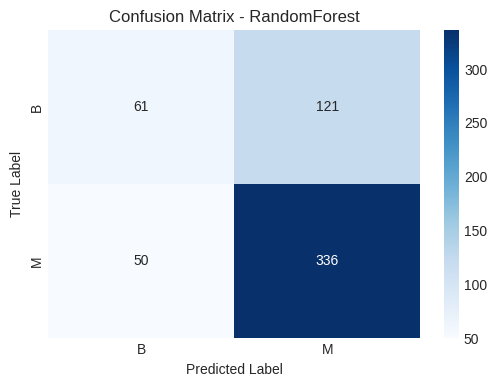

\nROC AUC Score: 0.7128


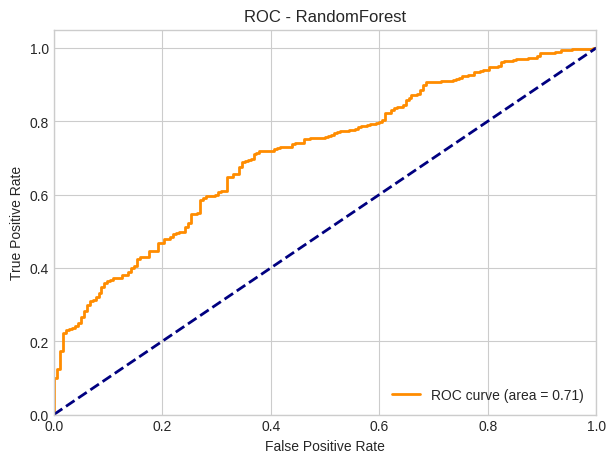

\n--- Evaluating MLP ---
\n--- Evaluation Metrics for: MLP on Test Set ---
Accuracy: 0.6761
\nClassification Report:
              precision    recall  f1-score   support

           B       0.48      0.11      0.18       182
           M       0.69      0.94      0.80       386

    accuracy                           0.68       568
   macro avg       0.58      0.53      0.49       568
weighted avg       0.62      0.68      0.60       568

\nConfusion Matrix:


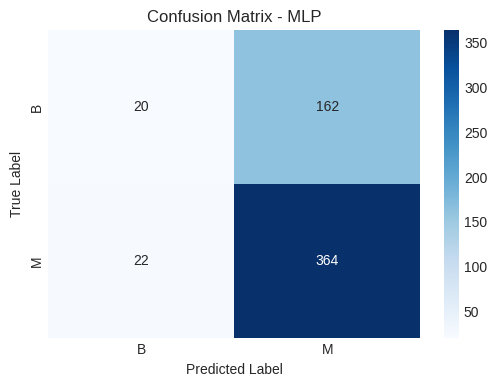

\nROC AUC Score: 0.6856


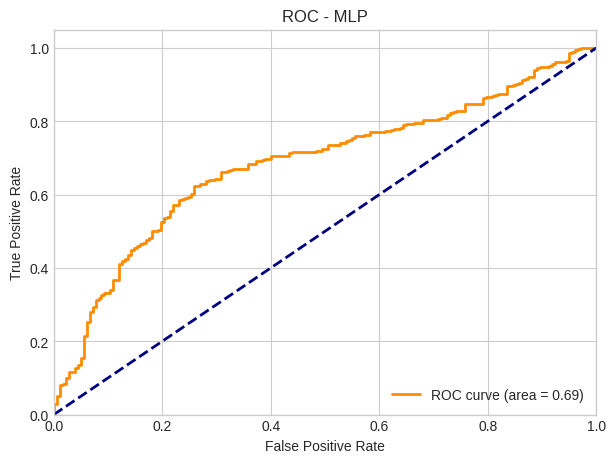

\n--- Evaluating LogisticRegression ---
\n--- Evaluation Metrics for: LogisticRegression on Test Set ---
Accuracy: 0.7377
\nClassification Report:
              precision    recall  f1-score   support

           B       0.57      0.70      0.63       182
           M       0.84      0.76      0.80       386

    accuracy                           0.74       568
   macro avg       0.71      0.73      0.71       568
weighted avg       0.76      0.74      0.74       568

\nConfusion Matrix:


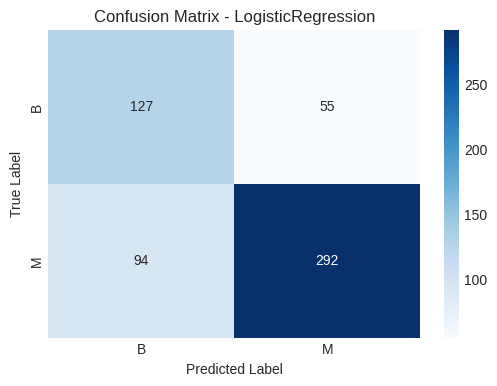

\nROC AUC Score: 0.7684


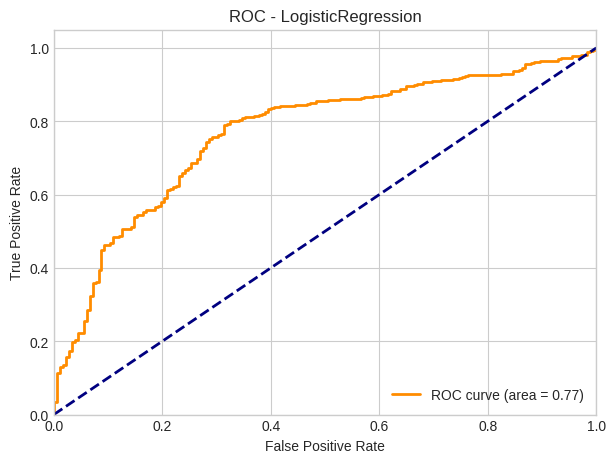

In [32]:
# Cell [18] (Example Number) - MODEL EVALUATION
print("\\n\\n=== Evaluating All Models on Test Set ===")

# Check if there are any valid test labels
if not X_test_scaled.empty and y_test.size > 0 and np.any(y_test != -1):
    for model_name, model_instance in models.items():
        if model_instance is not None:
            print(f"\\n--- Evaluating {model_name} ---")
            # THE CALL TO evaluate_model HAPPENS HERE
            acc, cm, roc = evaluate_model(
                model_name, model_instance, X_test_scaled, y_test, le)
            model_accuracies[model_name] = acc
            model_cms[model_name] = cm
            model_roc_aucs[model_name] = roc
        else:
            print(
                f"\\nSkipping evaluation for {model_name} as it was not trained successfully.")
            model_accuracies[model_name] = 0.0
            model_cms[model_name] = None
            model_roc_aucs[model_name] = None
elif X_test_scaled.empty or y_test.size == 0 or np.all(y_test == -1):
    print("\\nSkipping all model evaluations: Test data or labels are empty or invalid.")
else:  # Should not be reached if the first condition is met
    print("\\nSkipping all model evaluations: Training data was not processed, so no models were trained.")

## 9. Conclusion & Summary


In [33]:
# --- FINAL SUMMARY (Cell after Model Evaluation) ---
print("\\n\\n--- Final Summary ---")
# ... (initial print statements about data processing can remain the same) ...
if not df_all_images.empty:
    print(
        f"Processed {len(all_image_paths_info)} total images from {df_all_images['patient_slide_id'].nunique()} unique patient/slides.")
    if train_image_info_list:  # Check if list is not empty
        print(
            f"Used {len(train_image_info_list)} images for training feature extraction (from {len(set(item['patient_slide_id'] for item in train_image_info_list))} patients/slides).")
    if test_image_info_list:  # Check if list is not empty
        print(
            f"Used {len(test_image_info_list)} images for testing feature extraction (from {len(set(item['patient_slide_id'] for item in test_image_info_list))} patients/slides).")
print("\n")

if not X_train_scaled.empty:
    print(f"Training data samples after cleaning: {X_train_scaled.shape[0]}")
else:
    print("Training data: N/A or empty after cleaning.")

if not X_test_scaled.empty:
    print(f"Testing data samples after cleaning: {X_test_scaled.shape[0]}")
else:
    print("Testing data: N/A or empty after cleaning.")

print("\\n--- Model Performance on Test Set ---")
if model_accuracies:  # Check if any models were evaluated
    for model_name in models.keys():  # Iterate in the order they were defined
        if model_name in model_accuracies:
            print(
                f"Accuracy ({model_name}): {model_accuracies.get(model_name, 'N/A - Not Evaluated'):.4f}")
            if model_roc_aucs.get(model_name) is not None:
                print(
                    f"ROC AUC ({model_name}):  {model_roc_aucs[model_name]:.4f}")
            else:
                print(f"ROC AUC ({model_name}):  N/A")
        else:
            print(f"{model_name}: Not trained or evaluated.")
        
        print("====================")
    print("\\nReview detailed metrics (precision, recall, F1, Confusion Matrix) for each model above.")
else:
    print("No models were successfully trained or evaluated.")

print("\\n\\nConsiderations & Next Steps:")
print("- Segmentation Parameters: Ensure `SEGMENTATION_CONFIG` reflects your best tuned values for the target magnification(s).")
print("- Hyperparameter Tuning: For each model type, use GridSearchCV or RandomizedSearchCV on the *training set*.")
print("- Feature Importance/Selection: Analyze which features are most predictive for the best performing model(s).")
print("- Addressing Low Precision for Benign: This requires careful analysis of misclassified malignant cases (see previous detailed advice). It might involve segmentation tweaks, feature engineering, or model-specific adjustments like changing the decision threshold.")
print("- Ensemble Methods: Consider combining predictions from your top models.")

\n\n--- Final Summary ---
Processed 1995 total images from 82 unique patient/slides.
Used 1426 images for training feature extraction (from 61 patients/slides).
Used 569 images for testing feature extraction (from 21 patients/slides).


Training data samples after cleaning: 1425
Testing data samples after cleaning: 568
\n--- Model Performance on Test Set ---
Accuracy (SVC): 0.7254
ROC AUC (SVC):  0.7586
Accuracy (XGBoost): 0.6690
ROC AUC (XGBoost):  0.6505
Accuracy (RandomForest): 0.6989
ROC AUC (RandomForest):  0.7128
Accuracy (MLP): 0.6761
ROC AUC (MLP):  0.6856
Accuracy (LogisticRegression): 0.7377
ROC AUC (LogisticRegression):  0.7684
\nReview detailed metrics (precision, recall, F1, Confusion Matrix) for each model above.
\n\nConsiderations & Next Steps:
- Segmentation Parameters: Ensure `SEGMENTATION_CONFIG` reflects your best tuned values for the target magnification(s).
- Hyperparameter Tuning: For each model type, use GridSearchCV or RandomizedSearchCV on the *training set*.
-